## The task: Create summary tables that address relevant factors related to COVID-19

* Effectiveness of case isolation/isolation of exposed individuals (i.e. quarantine)
* Effectiveness of community contact reduction (i.e. social distancing)


### Approach
1. Filter Relevant papers (i.e. covid-19, quarantine-related, social distancing-related)
2. Extract the conclusions of these papers
3. Run topic modelling on the conclusions
4. Run summarization model on the conclusions
5. Run entity recognition on the conclusions
6. Create Summary tables


### Group 6
Ana Luísa de Melo Roberto, Ruslan Shchuchkin, Hsin Ting Hsieh

In [1]:
import numpy as np 
import pandas as pd 
import re
import matplotlib.pyplot as plt
import json
from gensim import models
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.corpora import Dictionary
from gensim.parsing.preprocessing import STOPWORDS, strip_tags, strip_numeric, strip_punctuation, strip_multiple_whitespaces, remove_stopwords, strip_short, stem_text
from scipy.spatial.distance import cdist

In [2]:
# Loading metadata
metadata = pd.read_csv('/kaggle/input/CORD-19-research-challenge/metadata.csv')
metadata.tail()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
192504,z4ro6lmh,203f36475be74229101548475d68352b939f8b5b,Medline; PMC,Rapid radiological improvement of COVID-19 pne...,10.1007/s15010-020-01449-w,PMC7299451,32557206,no-cc,NaN,2020-06-15,"Comel, Andrea Claudio; Mosaner, Walter; Bragan...",Infection,NaN,NaN,NaN,document_parses/pdf_json/203f36475be7422910154...,document_parses/pmc_json/PMC7299451.xml.json,https://doi.org/10.1007/s15010-020-01449-w; ht...,219729576.0
192505,hi8k8wvb,9f1bc99798e8823e690697394dcb23533a45c60e,Elsevier; Medline; PMC,SARS E protein in phospholipid bilayers: an an...,10.1016/j.physb.2004.11.015,PMC7127356,32288217,els-covid,Abstract We report on an anomalous X-ray refle...,2005-02-28,"Khattari, Z.; Brotons, G.; Arbely, E.; Arkin, ...",Physica B: Condensed Matter,NaN,NaN,NaN,document_parses/pdf_json/9f1bc99798e8823e69069...,document_parses/pmc_json/PMC7127356.xml.json,https://www.ncbi.nlm.nih.gov/pubmed/32288217/;...,122247693.0
192506,ma3ndg41,ffba777376718ef2a0dd74a8eab90e2bfacd240f,Medline; PMC,Italian Society of Interventional Cardiology (...,10.1002/ccd.28888,PMC7228289,32223063,no-cc,COVID‐19 pandemic raised the issue to guarante...,2020-04-11,"Tarantini, Giuseppe; Fraccaro, Chiara; Chieffo...",Catheter Cardiovasc Interv,NaN,NaN,NaN,document_parses/pdf_json/ffba777376718ef2a0dd7...,document_parses/pmc_json/PMC7228289.xml.json,https://www.ncbi.nlm.nih.gov/pubmed/32223063/;...,214715941.0
192507,wh10285j,d521c5a2dcbd79a5be606fcf586b1e0448344172,Medline; PMC,"Nimble, Together: A Training Program's Respons...",10.1097/sla.0000000000003994,PMC7224622,32355117,cc-by-nc-nd,NaN,2020-04-29,"Bryan, Darren S.; Benjamin, Andrew J.; Schneid...",Ann Surg,NaN,NaN,NaN,document_parses/pdf_json/d521c5a2dcbd79a5be606...,document_parses/pmc_json/PMC7224622.xml.json,https://www.ncbi.nlm.nih.gov/pubmed/32355117/;...,218468770.0
192508,pnl9th2c,c047bf76813106d4fd586e49164e7feddfbe352f,Elsevier; Medline; PMC,Vascular Life during the COVID-19 Pandemic Rem...,10.1016/j.ejvs.2020.04.040,PMC7214295,32446539,els-covid,NaN,2020-05-12,"Reyes Valdivia, Andrés; Gandarias Zúñiga, Clau...",Eur J Vasc Endovasc Surg,NaN,NaN,NaN,document_parses/pdf_json/c047bf76813106d4fd586...,NaN,https://www.sciencedirect.com/science/article/...,218582792.0


In [3]:
# Setting publish_time as timestamp for further calculation
metadata['publish_time'] = pd.to_datetime(metadata.publish_time)

## Step 1: selecting relevant articles

We decided to extract the relevant articles for our task by simple filtering. To that end, we prepared lists of synonyms and we only keep papers that contain at least one of the synonyms either in the title or in the abstract.


In [4]:
# List of COVID-19 synonyms
synonyms = [
    'coronavirus 2019',
    'coronavirus disease 19',
    'cov2',
    'cov-2',
    'covid',
    'ncov 2019',
    'covid-19',
    '2019ncov',
    '2019-ncov',
    '2019 ncov',
    'novel coronavirus',
    'sarscov2',
    'sars-cov-2',
    'sars cov 2',
    'severe acute respiratory syndrome coronavirus 2',
    'wuhan coronavirus',
    'wuhan pneumonia',
    'wuhan virus'
]

In [5]:
# List of synonyms about quarantine 
quarantine = [
    'quarantine',
    'stay at home',
    'vertical confinement',
    'vertical isolation',
    'infected people isolation',
    'isolation of infected people'
    'infected people seclusion',
    'seclusion of infected people'

]

In [6]:
# List of synonyms about social distancing
social_distancing = [
    'social distancing',
    'physical distancing',
    'horizontal isolation',
    'horizontal confinement',
    'community contact reduction',
    'reduction of community contact',
    'lockdown',
    'lock-down',
    'isolation policy',
    'isolation policies'
]

### Filtering

In [7]:
def filter_papers(synonym_list, data):
    """Takes a synonym list and a dataframe as  arguments and returns a subset of the df, filtered according to whether any of the synonyms
        is present either in the title or the abstract of the paper"""
    
    # List of titles. Null values gets substituted by "NA" for the indices to be the same as in the df
    titles = [title for title in data.loc[:,'title'].fillna(value="NA")] 

    # List of abtracts. Null values gets substituted by "NA" for the indices to be the same as in the df
    abstracts = [abstract for abstract in data.loc[:,'abstract'].fillna(value="NA")] 

    # Empty list of indices
    indices = [] 

    for i, title in enumerate(titles):                 # Loop through idices and titles in title list
        for syn in synonym_list:                       # Loop through synonyms in covid synonym list
            match = re.search(syn,title,flags=re.I)    # Check whether there is a match of any synonym in the title. Case insensitive
            if match != None:                          # If there is a match  append index to the list        
                indices.append(i)
                break                                  # leave the synonym list loop. One synonym match is enough
            
            else:                                      # If there is no title match, check the abstract for matches
                match = re.search(syn,abstracts[i],flags=re.I) 
                if match != None:                             
                    indices.append(i)                  # If there is a match  append index to the list 
                    break

    print("There are {0} related papers, by title and abstract".format(len(indices))) # Print the amount of papers retrieved
    
    return data.iloc[indices]                          # Return the filtered dataframe

In [8]:
# Covid papers
covid_papers = filter_papers(synonyms, metadata)
covid_papers.head()

There are 83574 related papers, by title and abstract


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
4456,wvx6q999,d958168df85240e544a918d843a14e887dc41d2b,PMC,Note from the editors: novel coronavirus (2019...,10.2807/1560-7917.es.2020.25.3.2001231,PMC6988271,3.19924e+07,cc-by,NaN,2020-01-23,NaN,Euro Surveill,NaN,NaN,NaN,document_parses/pdf_json/d958168df85240e544a91...,document_parses/pmc_json/PMC6988271.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,NaN
4582,2jq626ye,5a17ed3e4abf295f5820c65f56398266c1baae98,PMC,Therapeutic strategies in an outbreak scenario...,10.12688/f1000research.22211.2,PMC7029759,3.21176e+07,cc-by,A novel coronavirus (2019-nCoV) originating in...,2020-02-07,"Kruse, Robert L.",F1000Res,NaN,NaN,NaN,document_parses/pdf_json/5a17ed3e4abf295f5820c...,document_parses/pmc_json/PMC7029759.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN
4661,64q3qcjy,NaN,PMC,Latest assessment on COVID-19 from the Europea...,10.2807/1560-7917.es.2020.25.8.2002271,PMC7055041,3.21271e+07,cc-by,NaN,2020-02-27,NaN,Euro Surveill,NaN,NaN,NaN,NaN,NaN,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN
4697,bd7whqxf,NaN,PMC,Updated rapid risk assessment from ECDC on the...,10.2807/1560-7917.es.2020.25.9.2003051,PMC7068166,3.21563e+07,cc-by,NaN,2020-03-05,NaN,Euro Surveill,NaN,NaN,NaN,NaN,NaN,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN
4731,l3ijkmwy,NaN,PMC,Updated rapid risk assessment from ECDC on the...,10.2807/1560-7917.es.2020.25.10.2003121,PMC7078827,3.21839e+07,cc-by,NaN,2020-03-12,NaN,Euro Surveill,NaN,NaN,NaN,NaN,NaN,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN


In [9]:
# Filtering by date 
# to make sure papers are about covid-19 and not other coronaviruses
covid_papers = covid_papers[covid_papers.publish_time > '2019-12-01']
print(len(covid_papers))

82378


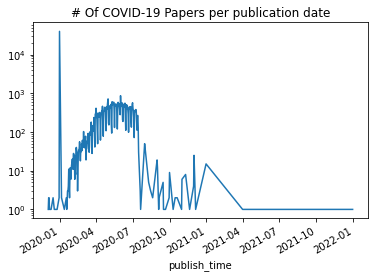

In [10]:
# Corona virus peak of papers in Jan 2020
# There are many papers published in the future
df = covid_papers.groupby('publish_time').count()
df.title.plot()
plt.title('# Of COVID-19 Papers per publication date')
plt.yscale('log')

In [11]:
# Quarantine
quarantine_papers = filter_papers(quarantine, covid_papers)
quarantine_papers.head()

There are 2336 related papers, by title and abstract


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
4582,2jq626ye,5a17ed3e4abf295f5820c65f56398266c1baae98,PMC,Therapeutic strategies in an outbreak scenario...,10.12688/f1000research.22211.2,PMC7029759,3.21176e+07,cc-by,A novel coronavirus (2019-nCoV) originating in...,2020-02-07,"Kruse, Robert L.",F1000Res,NaN,NaN,NaN,document_parses/pdf_json/5a17ed3e4abf295f5820c...,document_parses/pmc_json/PMC7029759.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN
11699,uan6rlvo,71e62a7ed85d47fa3a3204e013767898c2d2717c,PMC,Trauma Does not Quarantine: Violence During th...,10.1097/sla.0000000000003996,PMC7224619,3.23551e+07,cc-by-nc-nd,NaN,2020-04-29,"Hatchimonji, Justin S.; Swendiman, Robert A.; ...",Ann Surg,NaN,NaN,NaN,document_parses/pdf_json/71e62a7ed85d47fa3a320...,document_parses/pmc_json/PMC7224619.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN
21797,eykmhaya,13b33955abe2e204e92ca3ca52e3c8853c0e3093,PMC,Creating a “Quarantine Curriculum” to Enhance ...,10.1097/acm.0000000000003424,PMC7179056,NaN,no-cc,NaN,2020-04-22,"Ross, David A.",Acad Med,NaN,NaN,NaN,document_parses/pdf_json/13b33955abe2e204e92ca...,document_parses/pmc_json/PMC7179056.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN
22705,x7t7thg1,db9b1a30d2e47bbf1c48accca3c3d87eefd69f8b,PMC,Translation: Management of Coronavirus Disease...,10.1097/im9.0000000000000023,PMC7227201,NaN,cc-by-nc-nd,The current epidemic situation of coronavirus ...,2020-04-17,"Xu, Kaijin; Cai, Hongliu; Shen, Yihong; Ni, Qi...",NaN,NaN,NaN,NaN,document_parses/pdf_json/db9b1a30d2e47bbf1c48a...,document_parses/pmc_json/PMC7227201.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN
23597,ovizjbnq,1de1673afdec092ddbd9c214cef28d7640ac5805,PMC,A suspected case of COVID-19 turned into a con...,10.2217/fvl-2020-0030,PMC7265682,NaN,cc-by,COVID-19 (coronavirus disease 2019) is an infe...,2020-05-29,"Yang, Di; Wei, Kai; Gao, Xuesong; Zhang, Yijin...",NaN,NaN,NaN,NaN,document_parses/pdf_json/1de1673afdec092ddbd9c...,document_parses/pmc_json/PMC7265682.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN


In [12]:
# Visual inspection: In a reasonable portion of the papers, the word quarantine appears but it is not the main point of the paper
# A further cleaning step is needed
indices = [idx for idx in quarantine_papers.index]
current = 52
print(quarantine_papers.loc[indices[current], 'title'])
print(quarantine_papers.loc[indices[current], 'abstract'])

Infection of dogs with SARS-CoV-2.
SARS-CoV-2 emerged in Wuhan in December 2019 and caused the pandemic respiratory disease, COVID-191,2. In 2003, the closely related SARS-CoV had been detected in domestic cats and a dog3. However, little is known about the susceptibility of domestic pet mammals to SARS-CoV-2. Two out of fifteen dogs from households with confirmed human cases of COVID-19 in Hong Kong SAR were found to be infected using quantitative RT-PCR, serology, sequencing the viral genome, and in one dog, virus isolation. SARS-CoV-2 RNA was detected in a 17-year-old neutered male Pomeranian from five nasal swabs collected over a 13-day period. A 2.5-year-old male German Shepherd dog had SARS CoV-2 RNA on two occasions and virus was isolated from nasal and oral swabs. Both dogs had antibody responses detected using plaque reduction neutralization assays. Viral genetic sequences of viruses from the two dogs were identical to the virus detected in the respective human cases. The anim

In [13]:
# Social_distancing
social_distancing_papers = filter_papers(social_distancing, covid_papers)
social_distancing_papers.head()

There are 5218 related papers, by title and abstract


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
10564,9vcsu34j,NaN,PMC,Touch Me Not: Physical Distancing in Radiology...,10.1016/j.jacr.2020.04.019,PMC7174167,3.23605e+07,no-cc,NaN,2020-04-22,"Chen, Robert Chun; Tim-Ee Cheng, Lionel; Liang...",J Am Coll Radiol,NaN,NaN,NaN,NaN,NaN,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN
10630,ozmmt9xo,NaN,PMC,India under COVID-19 lockdown,10.1016/s0140-6736(20)30938-7,PMC7180023,3.23347e+07,no-cc,NaN,2020-04-23,The Lancet,Lancet,NaN,NaN,NaN,NaN,NaN,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN
12130,010xjb35,07686808237f363283c4bace5640b23b8c5d5435,PMC,COVID-19 and neurointerventional service world...,10.1136/neurintsurg-2020-016349,PMC7316120,3.25466e+07,no-cc,BACKGROUND: This survey was focused on the pro...,2020-06-16,"Fiehler, Jens; Brouwer, Patrick; Díaz, Carlos;...",J Neurointerv Surg,NaN,NaN,NaN,document_parses/pdf_json/07686808237f363283c4b...,document_parses/pmc_json/PMC7316120.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN
21835,da11hkee,1bfe83306140d18c803bd60c367b0e0dd8b8bba1,PMC,China’s Blacklist System under the Covid-19 Pr...,10.1007/s42438-020-00127-2,PMC7183742,NaN,no-cc,NaN,2020-04-26,"Hu, Zhengdong",Postdigit Sci Educ,NaN,NaN,NaN,document_parses/pdf_json/1bfe83306140d18c803bd...,document_parses/pmc_json/PMC7183742.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN
21957,x1u70y1x,2186cc8d2832a4501406a4f597ae20f63df4fdac,PMC,Prevention and Control Strategies for SARS-CoV...,10.1007/978-981-15-4814-7_11,PMC7189388,NaN,no-cc,The population of 168 countries all over the w...,2020-04-30,"Srivastava, Nishant; Saxena, Shailendra K.",Coronavirus Disease 2019 (COVID-19),NaN,NaN,NaN,document_parses/pdf_json/2186cc8d2832a4501406a...,document_parses/pmc_json/PMC7189388.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN


In [14]:
# Visual inspection: Same issue. Many papers mention Social Distancing, but they are not about the effectiveness of social distancing
indices = [idx for idx in social_distancing_papers.index]
current = 305
print(social_distancing_papers.loc[indices[current], 'title'])
print(social_distancing_papers.loc[indices[current], 'abstract'])

Impact of lockdown following COVID-19 on the gaming behavior of college students.
Background The uncertainty about the impact of the lockdown in wake of COVID-19 on their future academic and carrier prospects, besides other concerns; makes college students, particularly vulnerable to stress during the COVID-19 pandemic. Gaming has been recognized as a coping mechanism against stress in the previously published literature. Objectives The current study aimed to assess the gaming behavior of college students during the lockdown following COVID-19. Methods Data were collected from a cohort of students that constituted the sampling frame of an ongoing project. A total of 393 college students were enrolled. All the eligible students were subsequently contacted through E-mail and WhatsApp messenger and invited to share the details. Results About half (50.8%) of the participants reported that their gaming behavior had increased, whereas 14.6% reported a decrease in their gaming during the lock

## Step 2: Parsing Json to extract conclusions
Again, we base ourselves on a list of possible conclusion section terms and run a regular expression search to retrieve the paragraphs that belong in the sections whose title contain any of the specified terms

In [15]:
#Printing Schema for inspection
schema = open('/kaggle/input/CORD-19-research-challenge/json_schema.txt', "r") 
print(schema.read())

# JSON schema of full text documents


{
    "paper_id": <str>,                      # 40-character sha1 of the PDF
    "metadata": {
        "title": <str>,
        "authors": [                        # list of author dicts, in order
            {
                "first": <str>,
                "middle": <list of str>,
                "last": <str>,
                "suffix": <str>,
                "affiliation": <dict>,
                "email": <str>
            },
            ...
        ],
        "abstract": [                       # list of paragraphs in the abstract
            {
                "text": <str>,
                "cite_spans": [             # list of character indices of inline citations
                                            # e.g. citation "[7]" occurs at positions 151-154 in "text"
                                            #      linked to bibliography entry BIBREF3
                    {
                        "start": 151,
                        "end": 1

In [16]:
def get_conclusion_df(filtered_papers):
    """Takes filtered papers as input and return a dataframe with paper index and conlusion texts."""
    
    print('number of filtered papers:', filtered_papers.shape[0])

    json_papers = filtered_papers.copy()
    json_papers = json_papers.pdf_json_files.dropna() # Dropping papers that don't have full text in pdf_json column
    
    paths = [r'/kaggle/input/CORD-19-research-challenge/{0}'.format(filtered_papers.pdf_json_files[i]) for i in json_papers.index] # Paths to load json files
 
    paper_conclusions = {} # Empty dictionary that will contain conclusion texts per paper 

    for i in range(len(paths)):

        # Loading json files 
        try:
            with open(paths[i]) as data_file:                         
                data = json.load(data_file)
        except:
            continue

        conlusion = ''

        # Parsing all sections per paper
        for j in range(len(data['body_text'])):      
            
            # Get each secion in the paper
            sec = str(data['body_text'][j]['section'])

            # List of possible words contained in a conclusion-like section
            cons = ['conclusions', 'conclusion', 'outcomes', 'discussion', 'concluding', 'discuss']#, 'results', 'summary']

            # Retrieving the text of sections whose titles contain any of the terms in the list
            if any(re.search(con, sec, flags=re.I) for con in cons):  
                conlusion += data['body_text'][j]['text']
                conlusion += ' '

        paper_conclusions[json_papers.index[i]] = conlusion

    conc_df = pd.DataFrame({'paper_id': list(paper_conclusions.keys()), 'raw_conclusion': list(paper_conclusions.values())})

    # If there is no conclusion we use paper abastract instead
    print('number of papers with json data:', conc_df.shape[0])
    print('number of papers with conclusion', conc_df[conc_df.raw_conclusion != ''].shape[0])
    conc_df['raw_conclusion'] = np.where(conc_df['raw_conclusion'] != '', conc_df['raw_conclusion'], filtered_papers.loc[conc_df['paper_id'], 'abstract'])

    # Removing the rows that are still without conclusion
    conc_df = conc_df[conc_df['raw_conclusion'].notna()]

    return conc_df

In [17]:
quarantine_conc_df = get_conclusion_df(quarantine_papers)
quarantine_conc_df

number of filtered papers: 2336
number of papers with json data: 917
number of papers with conclusion 632


,paper_id,raw_conclusion
0,4582,The chief objective of global health efforts a...
3,22705,The current epidemic situation of coronavirus ...
4,23597,Her pharyngeal symptoms disappeared gradually ...
5,23699,"On the 26th February 2020, a meeting was held ..."
6,23719,We establish a mathematical model called SIDCR...
...,...,...
912,192059,This study shows a holistic picture of the cur...
913,192243,"OBJECTIVES: Since January 23rd, 2020, stringen..."
914,192257,"Abstract With over 1,800,000 cases and 110,000..."
915,192360,Public health nurses (PHNs) are on the frontli...


In [18]:
social_distancing_conc_df = get_conclusion_df(social_distancing_papers)
social_distancing_conc_df

number of filtered papers: 5218
number of papers with json data: 2284
number of papers with conclusion 1626


,paper_id,raw_conclusion
0,12130,"This survey, conducted between April 2 and Apr..."
2,21957,COVID-19 or SARS-CoV-2 is a novel virus having...
3,21961,Our understanding with the ongoing COVID-19 di...
4,21967,"On March 19, 2020, worldwide 191,127 confirmed..."
5,21972,SARS-CoV-2 is a highly infectious virus with t...
...,...,...
2279,192180,As the Coronavirus disease 2019 (COVID-19) pan...
2280,192251,It should be noted that this data was collecte...
2281,192363,The coronavirus disease worldwide outbreak has...
2282,192407,COVID-19 represents the largest pandemic of th...


### Text Preprocessing
Removing urls and recurring copyright, doi and other publication disclaimers. 


Removing numbers, puctuation, multiple whitespaces, stowords, short words, lowercasing and stemming the text

In [19]:
def stem_conclusion(conc_df):
    df = conc_df.copy()
    df.loc[:, 'conclusion'] = df['raw_conclusion'].apply(lambda content: strip_numeric(content))
    df.loc[:, 'conclusion'] = df['conclusion'].apply(lambda content: strip_punctuation(content))
    df.loc[:, 'conclusion'] = df['conclusion'].apply(lambda content: strip_multiple_whitespaces(content))
    df.loc[:, 'conclusion'] = df.loc[:,'conclusion'].str.lower()
    df.loc[:, 'conclusion'] = df['conclusion'].apply(lambda content: remove_stopwords(content))
    df.loc[:, 'conclusion'] = df['conclusion'].apply(lambda content: strip_short(content))
    df.loc[:, 'stemmed_conclusion'] = df['conclusion'].apply(lambda content: stem_text(content))
    return df

In [20]:
def rem_disclaimers(string):
    '''Removes URLs, as well as copyright and other disclaimers from the conclusion text'''
    
    URL_pattern = r"""(?i)((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info
                      |int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|
                      bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|
                      cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|
                      gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|
                      la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|
                      nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|
                      sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|
                      uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]
                      *?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’])|(?:(?<!@)
                      [a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name
                      |post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn
                      |bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg
                      |eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id
                      |ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|
                      md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|
                      ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|
                      sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|
                      za|zm|zw)\b/?(?!@)))"""
    
    disclaimer_list = [URL_pattern,
                       r'all rights reserved.*?\.',
                       r'no reuse allowed without permission.*?\.',
                       r'is the author/funder, who has granted.*?\.',
                       r'international license',
                       r'It is made available under a',
                       r'which was not certified by peer review',
                       r'The copyright holder.*?\.',
                       r'doi: medRxiv preprint',
                       r'doi:?']
    
    matches = []
    for expression in disclaimer_list:
        m =  re.findall(expression, string, flags=re.I)
        matches.extend(m) 
    
    for expression in matches:
        string = re.sub(expression,"",string,flags=re.I)
        
    
    return string

In [21]:
#Little issue with the parenthesis. For some reason they don't get deleted even if they are part of the match
conc_test = quarantine_conc_df.loc[52,'raw_conclusion']
rem_disclaimers(conc_test)

'The finding that persons older than 42 years have longer incubation periods than those who are younger has important implications for enacting age-specific quarantine policies. This result agrees with previous studies on Severe Acute Respiratory Syndrome that showed a relationship between age 4 . CC-BY-NC-ND 4.0    '

In [22]:
quarantine_conc_df.loc[:,'raw_conclusion'] = quarantine_conc_df.loc[:,'raw_conclusion'].apply(lambda string: rem_disclaimers(string))
social_distancing_conc_df.loc[:,'raw_conclusion'] = social_distancing_conc_df.loc[:,'raw_conclusion'].apply(lambda string: rem_disclaimers(string))

error: missing ), unterminated subpattern at position 39

In [23]:
# Iterating through social distacing df to capture where the problem is
# It looks like those were the only papers in which those disclaimers were present
# Don't get where this is coming from, but since it is only 7 papers which are problematic, I will ignore it for now 

for i in social_distancing_conc_df.index:
    try:
        social_distancing_conc_df.loc[i,'raw_conclusion'] = rem_disclaimers(social_distancing_conc_df.loc[i,'raw_conclusion'])
    except:
        print(i)
        continue 

285
593
636
724
755
804
832
1221


In [24]:
social_distancing_conc_df.loc[565,'raw_conclusion']

'Modeling and analyzing the spread of COVID-19, and assessing the effect of various policies could be instrumental to national and international agencies for health response planning (9, 14, 21, 28, 36, 38) . We show that the effect of interstate travel reduction is at most modest in the United States when the outbreak has already widespread in all states. On the other hand, we need to impose strong transmission-reduction intervention and increased testing capacity and report rate to contain the spread of virus. The result is in agreement with previous findings (9, 12, 14, 23, 36, 40) , suggesting that the effect of travel ban at a later stage of the outbreak is rather modest. This is also in line with the fact that the outbreaks still occurred in Europe even upon the strong travel ban on the earlier epicenter of Wuhan and its surrounding cities in China. We also show that the transmission-reduction intervention such as policies on the social-distancing and shelter-in-place rules, and 

In [25]:
rem_disclaimers(social_distancing_conc_df.loc[565,'raw_conclusion'])

'Modeling and analyzing the spread of COVID-19, and assessing the effect of various policies could be instrumental to national and international agencies for health response planning (9, 14, 21, 28, 36, 38) . We show that the effect of interstate travel reduction is at most modest in the United States when the outbreak has already widespread in all states. On the other hand, we need to impose strong transmission-reduction intervention and increased testing capacity and report rate to contain the spread of virus. The result is in agreement with previous findings (9, 12, 14, 23, 36, 40) , suggesting that the effect of travel ban at a later stage of the outbreak is rather modest. This is also in line with the fact that the outbreaks still occurred in Europe even upon the strong travel ban on the earlier epicenter of Wuhan and its surrounding cities in China. We also show that the transmission-reduction intervention such as policies on the social-distancing and shelter-in-place rules, and 

In [26]:
quarantine_conc_df = stem_conclusion(quarantine_conc_df)
quarantine_conc_df

,paper_id,raw_conclusion,conclusion,stemmed_conclusion
0,4582,The chief objective of global health efforts a...,chief objective global health efforts ncov rem...,chief object global health effort ncov remain ...
3,22705,The current epidemic situation of coronavirus ...,current epidemic situation coronavirus disease...,current epidem situat coronaviru diseas covid ...
4,23597,Her pharyngeal symptoms disappeared gradually ...,pharyngeal symptoms disappeared gradually body...,pharyng symptom disappear gradual bodi tempera...
5,23699,"On the 26th February 2020, a meeting was held ...",february meeting held royal society medicine k...,februari meet held royal societi medicin kei a...
6,23719,We establish a mathematical model called SIDCR...,establish mathematical model called sidcrl mod...,establish mathemat model call sidcrl model dyn...
...,...,...,...,...
912,192059,This study shows a holistic picture of the cur...,study shows holistic picture current research ...,studi show holist pictur current research resp...
913,192243,"OBJECTIVES: Since January 23rd, 2020, stringen...",objectives january stringent measures controll...,object januari stringent measur control novel ...
914,192257,"Abstract With over 1,800,000 cases and 110,000...",abstract cases deaths globally covid worst inf...,abstract case death global covid worst infecti...
915,192360,Public health nurses (PHNs) are on the frontli...,public health nurses phns frontline public hea...,public health nurs phn frontlin public health ...


In [27]:
social_distancing_conc_df = stem_conclusion(social_distancing_conc_df)
social_distancing_conc_df

,paper_id,raw_conclusion,conclusion,stemmed_conclusion
0,12130,"This survey, conducted between April 2 and Apr...",survey conducted april april provides snapshot...,survei conduct april april provid snapshot dev...
2,21957,COVID-19 or SARS-CoV-2 is a novel virus having...,covid sars cov novel virus having close geneti...,covid sar cov novel viru have close genet rese...
3,21961,Our understanding with the ongoing COVID-19 di...,understanding ongoing covid disaster shows chi...,understand ongo covid disast show children low...
4,21967,"On March 19, 2020, worldwide 191,127 confirmed...",march worldwide confirmed cases reported morta...,march worldwid confirm case report mortal conf...
5,21972,SARS-CoV-2 is a highly infectious virus with t...,sars cov highly infectious virus ability human...,sar cov highli infecti viru abil human human t...
...,...,...,...,...
2279,192180,As the Coronavirus disease 2019 (COVID-19) pan...,coronavirus disease covid pandemic spread glob...,coronaviru diseas covid pandem spread global e...
2280,192251,It should be noted that this data was collecte...,noted data collected line users kanagawa volun...,note data collect line user kanagawa voluntari...
2281,192363,The coronavirus disease worldwide outbreak has...,coronavirus disease worldwide outbreak led dra...,coronaviru diseas worldwid outbreak led dramat...
2282,192407,COVID-19 represents the largest pandemic of th...,covid represents largest pandemic century high...,covid repres largest pandem centuri highli con...


In [28]:
def create_corpus(df_col, min_freq, max_freq, stopwords_list):
    '''Creates a gensim corpus, filters it based on a user-defined stopwords list
       and finally derives a BoW based on the given input. Returns the corpus and dictionary'''
    
    # Creation of corpus in gensim
    corpus_gen = [doc.split() for doc in df_col]
    
    # Removing extra defined stopwords
    corpus_clean = [[w for w in doc if w not in stopwords_list] for doc in corpus_gen]
    
    # Building the dictionary
    dictionary = Dictionary(corpus_clean)
    print("Before filtering {0}".format(dictionary))
    
    # Filtering out extremes
    dictionary.filter_extremes(no_below=min_freq, no_above=max_freq)
    print("After filtering {0}".format(dictionary))
    
    #Bag of words
    corpus = [dictionary.doc2bow(doc) for doc in corpus_clean] 
    
    return corpus, dictionary

In [29]:
# Words to be removed from corpus
rem_words = ['covid','coronaviru','cov', 'sar', 'diseas', 'pandem','epidem','outbreak','case','care','viru','respiratori', 'viral',
             'author','time', 'need', 'data', 'sampl', 'report']

# Both Dictionaries are around 300 tokens
print("Quarantine:")
corpus_quarantine, quarantine_dict = create_corpus(quarantine_conc_df['stemmed_conclusion'], min_freq=70, max_freq=0.95, stopwords_list = rem_words )

print("\nSocial Distancing:")
corpus_social_dist, social_dist_dict = create_corpus(social_distancing_conc_df['stemmed_conclusion'], min_freq=160, max_freq=0.95, stopwords_list = rem_words )

Quarantine:
Before filtering Dictionary(9257 unique tokens: ['ac', 'action', 'activ', 'acut', 'addit']...)
After filtering Dictionary(392 unique tokens: ['action', 'activ', 'acut', 'addit', 'assess']...)

Social Distancing:
Before filtering Dictionary(15154 unique tokens: ['abandon', 'absolut', 'access', 'accord', 'achiev']...)
After filtering Dictionary(403 unique tokens: ['access', 'accord', 'achiev', 'activ', 'adopt']...)


## **Step 3: LDA Topic Modelling**
This approach aims on further cleaning the Conclusion DFs to keep only those that truly address the effectiveness of quarantine and social distancing policies. This is done by runnind LDA topic modelling with a varying number of topics and selecting the one which contains the most interesting topics.
* Quarantine papers
    - **9 Topics - 4,5,7,8**

In [30]:
#Interesting words for which to be in the look-out: quarantine, contact, isol, effect, spread, transmission, infect, risk, studi, model
lda = models.LdaModel(corpus_quarantine, num_topics=9, id2word=quarantine_dict, iterations=100, passes=10, random_state = 42)
lda.show_topics()

[(0,
  '0.025*"preprint" + 0.019*"studi" + 0.017*"knowledg" + 0.016*"medrxiv" + 0.013*"health" + 0.013*"doi" + 0.012*"social" + 0.012*"quarantin" + 0.012*"behavior" + 0.012*"prevent"'),
 (1,
  '0.074*"patient" + 0.032*"test" + 0.025*"infect" + 0.021*"studi" + 0.018*"symptom" + 0.015*"clinic" + 0.014*"result" + 0.013*"posit" + 0.013*"hospit" + 0.012*"dai"'),
 (2,
  '0.033*"social" + 0.024*"contact" + 0.023*"distanc" + 0.018*"measur" + 0.018*"effect" + 0.015*"trace" + 0.014*"public" + 0.014*"isol" + 0.013*"us" + 0.013*"commun"'),
 (3,
  '0.021*"measur" + 0.015*"quarantin" + 0.014*"control" + 0.014*"result" + 0.014*"scenario" + 0.014*"activ" + 0.014*"infect" + 0.013*"prevent" + 0.012*"effect" + 0.012*"differ"'),
 (4,
  '0.052*"period" + 0.045*"dai" + 0.041*"incub" + 0.030*"studi" + 0.029*"estim" + 0.022*"transmiss" + 0.021*"symptom" + 0.019*"infect" + 0.018*"quarantin" + 0.015*"onset"'),
 (5,
  '0.048*"model" + 0.034*"infect" + 0.028*"quarantin" + 0.026*"number" + 0.018*"popul" + 0.014*"e

In [31]:
topics=lda[corpus_quarantine]
quarantine_conc_df['topics_lda']= [max(topics[i])[0] for i in range(len(topics))]
quarantine_conc_df.head()

,paper_id,raw_conclusion,conclusion,stemmed_conclusion,topics_lda
0,4582,The chief objective of global health efforts a...,chief objective global health efforts ncov rem...,chief object global health effort ncov remain ...,8
3,22705,The current epidemic situation of coronavirus ...,current epidemic situation coronavirus disease...,current epidem situat coronaviru diseas covid ...,8
4,23597,Her pharyngeal symptoms disappeared gradually ...,pharyngeal symptoms disappeared gradually body...,pharyng symptom disappear gradual bodi tempera...,1
5,23699,"On the 26th February 2020, a meeting was held ...",february meeting held royal society medicine k...,februari meet held royal societi medicin kei a...,8
6,23719,We establish a mathematical model called SIDCR...,establish mathematical model called sidcrl mod...,establish mathemat model call sidcrl model dyn...,5


In [32]:
effect_quarantine_df = quarantine_conc_df.loc[(quarantine_conc_df['topics_lda'] == 5) | 
                                              (quarantine_conc_df['topics_lda'] == 7) |
                                              (quarantine_conc_df['topics_lda'] == 8),['paper_id','raw_conclusion', 'topics_lda']]

print("Number of quarantine papers {0}".format(effect_quarantine_df.shape[0]))
effect_quarantine_df.head()

Number of quarantine papers 634


,paper_id,raw_conclusion,topics_lda
0,4582,The chief objective of global health efforts a...,8
3,22705,The current epidemic situation of coronavirus ...,8
5,23699,"On the 26th February 2020, a meeting was held ...",8
6,23719,We establish a mathematical model called SIDCR...,5
7,24186,"As the largest quarantine in human history, th...",8


* 8 - bad, good, bad, bad, good, good, good, good, good, good - pass
* 7- good, okayish, good, good, good, bad, okayish, good, good, good - pass
* 4 - okayish, okayish, good, bad, okayish, good,bad, good, bad, bad, bad, bad - can be deleted, there are only 48 papers and results are not impressive
* 5 - good, good, okayish, good, okayish, good, good, okayish, good, good - pass
* 0 - good, bad, bad, bad, bad - only these ones. Can be deleted

In [33]:
# Visual inspection
indices = [idx for idx in effect_quarantine_df.index]
print(effect_quarantine_df.loc[660, 'raw_conclusion'])

L'épidémie du coronavirus est une pandémie, elle concerne la population humaine à l'échelle mondiale. Les mesures gouvernementales mises en oeuvre pour lutter contre cette épidémie ont des répercussions pour tous. Ainsi l'ensemble des patients accueillis en hôpital de jour psychiatrique s'est entendu demander de rester chez soi et de respecter des règles de distanciation sociale. Et nous, devant un paradoxe incontournable quand notre travail consiste précisément à dé-confiner, à relier, à être au contact, cela nous a contraints à repenser les fonctions essentielles du soin. Le confinement concourt à la suspension de ce qui va ordinairement de soi dans le « lien social » (se voir, s'embrasser, se toucher, discuter…) et produit un effet de perte d'évidence naturelle dans la relation [15] immédiatement perceptible. Les conséquences mortelles du virus sont pour leur part disséminées dans la totalité de la population, où nous ne reconnaissons un semblable qu'en potentialité : l'altérité que

* Social Distance papers
    - 9 Topics - 0,2,3,4,5


In [34]:
#Interesting words for which to be in the look-out: contact, isol, social, distanc, lockdown, polici, effect, measure, reduct, number
lda2 = models.LdaModel(corpus_social_dist, num_topics=9, id2word=social_dist_dict, iterations=100, passes=10, random_state = 42)
lda2.show_topics()

[(0,
  '0.033*"transmiss" + 0.026*"contact" + 0.023*"model" + 0.022*"estim" + 0.022*"effect" + 0.021*"infect" + 0.021*"control" + 0.020*"measur" + 0.018*"intervent" + 0.017*"number"'),
 (1,
  '0.061*"social" + 0.037*"activ" + 0.036*"distanc" + 0.031*"peopl" + 0.028*"health" + 0.028*"behavior" + 0.021*"group" + 0.019*"prevent" + 0.018*"risk" + 0.016*"increas"'),
 (2,
  '0.038*"studi" + 0.024*"health" + 0.023*"ag" + 0.020*"popul" + 0.019*"level" + 0.015*"higher" + 0.015*"mental" + 0.015*"group" + 0.014*"find" + 0.014*"result"'),
 (3,
  '0.104*"lockdown" + 0.028*"reduct" + 0.025*"effect" + 0.023*"level" + 0.023*"citi" + 0.022*"period" + 0.019*"studi" + 0.018*"qualiti" + 0.018*"activ" + 0.017*"measur"'),
 (4,
  '0.021*"health" + 0.015*"provid" + 0.014*"commun" + 0.013*"work" + 0.012*"public" + 0.011*"servic" + 0.011*"us" + 0.011*"research" + 0.011*"respons" + 0.011*"measur"'),
 (5,
  '0.032*"march" + 0.031*"area" + 0.026*"region" + 0.024*"citi" + 0.021*"mobil" + 0.019*"differ" + 0.019*"mon

In [35]:
topics2=lda2[corpus_social_dist]
social_distancing_conc_df['topics_lda']= [max(topics2[i])[0] for i in range(len(topics2))]
social_distancing_conc_df.head()

,paper_id,raw_conclusion,conclusion,stemmed_conclusion,topics_lda
0,12130,"This survey, conducted between April 2 and Apr...",survey conducted april april provides snapshot...,survei conduct april april provid snapshot dev...,8
2,21957,COVID-19 or SARS-CoV-2 is a novel virus having...,covid sars cov novel virus having close geneti...,covid sar cov novel viru have close genet rese...,6
3,21961,Our understanding with the ongoing COVID-19 di...,understanding ongoing covid disaster shows chi...,understand ongo covid disast show children low...,4
4,21967,"On March 19, 2020, worldwide 191,127 confirmed...",march worldwide confirmed cases reported morta...,march worldwid confirm case report mortal conf...,6
5,21972,SARS-CoV-2 is a highly infectious virus with t...,sars cov highly infectious virus ability human...,sar cov highli infecti viru abil human human t...,8


In [36]:
effect_social_dist_df = social_distancing_conc_df.loc[(social_distancing_conc_df['topics_lda'] != 1) &
                                                      (social_distancing_conc_df['topics_lda'] != 6) & 
                                                      (social_distancing_conc_df['topics_lda'] != 7) &
                                                      (social_distancing_conc_df['topics_lda'] != 8),['paper_id','raw_conclusion']]

print("Number of Social Distancing papers {0}".format(effect_social_dist_df.shape[0]))
effect_social_dist_df.head()

Number of Social Distancing papers 444


,paper_id,raw_conclusion
3,21961,Our understanding with the ongoing COVID-19 di...
8,22577,An understanding of the role of place in the w...
11,23697,This paper provides a timely estimation of the...
17,25550,The COVID-19 pandemic is having an unprecedent...
19,25732,The COVID-19 pandemic created social upheaval ...


* 0 - bad,bad, good,good, okayish, good - only has those. It can stay
* 2 - bad, bad, good, bad, bad, okayish, good, good, good,good - pass
* 3 - good, good, okayish, good, good, good, okayish, good, bad, good - pass
* 4 - okayish, okayish, good, bad, okayish, good, good, good, good, good - pass
* 5 - bad, good, good,good, good, good, good, good, good, good - pass

In [37]:
# Visual inspection
indices = [idx for idx in effect_social_dist_df.index]
print(effect_social_dist_df.loc[40, 'raw_conclusion'])

The COVID-19 crisis has brought the shortcomings of UK food welfare policy, the central role of the voluntary sector, and the major dependence of the UK on philanthropy into sharp relief. Much of the government response was piecemeal and driven by pressure groups and charities. It sought populist plasters rather than address the deep causes of food insecurity through proper planning. This whole crisis has been exacerbated by reliance of the economy on precarious employment, especially within those sectors that were shut down. The sudden emergence of the precariat as a group vulnerable to food insecurity raises new questions about understanding the constraints that precarious working imposes on food habits, dietary inadequacies and dietary excess. The government needs to establish a framework for employment and social security that has appropriate measures to safeguard casual workers, who are particularly vulnerable to economic shocks from a pandemic or a political sea change such as Br

## Step4: Summarizing Conclusions with BertSumExt
### Step4-1: Preparing data

In [38]:
def format_to_bertsumm(text):
    '''For using BertSumExt service, we need to format the conclusion to certain format.
    In this funciton, we insert tokens between sentences'''

    pattern = '\w\s"“”#%&\'()*+,/:;<=>@[\\]^_`{|}~$£€-'
    processed_text = re.sub('[A-Z][{}]+[?.!]'.format(pattern), '\g<0> [CLS] [SEP]', text)
    processed_text = processed_text.rsplit(' [CLS] [SEP]', 1)[0]
    return processed_text

In [39]:
effect_quarantine_df['presumm_text'] = effect_quarantine_df['raw_conclusion'].apply(format_to_bertsumm)
effect_social_dist_df['presumm_text'] = effect_social_dist_df['raw_conclusion'].apply(format_to_bertsumm)

In [40]:
# Preview result
effect_quarantine_df['presumm_text'].iloc[3]

'We establish a mathematical model called SIDCRL model with dynamic social factors illustrating epidemic situations in China, South Korea, Italy, and the United States. [CLS] [SEP] The model coincides with the actual situation and gives predictions. [CLS] [SEP] Also, it can be induced from the simulation that the increasing number of SCCs contributes to the epidemic outbreak.'

In [41]:
# Preview result
effect_social_dist_df['presumm_text'].iloc[320]

"Many universities documented similar pedagogical opportunities and challenges. [CLS] [SEP] Themes from the responses to top opportunities and challenges are sorted into a SWOT analysis and used to form the basis of this discussion. [CLS] [SEP] Reoccurring strengths included the development of new resources and skills. [CLS] [SEP] Time constraints, lack of exposure to cadaveric material, and changes to assessment were identified as weaknesses. [CLS] [SEP] Opportunities identified included academic collaboration and working remotely, as well as with the opportunity to implement blended learning in future curriculum development. [CLS] [SEP] The reduction in quality of resources, reduced student engagement, and diminished student-teacher relationship were considered threats (Fig. [CLS] [SEP] 1 ). The approaches taken by higher education institutions and the effect these have on the strengths, weaknesses, opportunities, and threats currently faced are also discussed to elicit which approac

In [42]:
def write_txt(prefix, row):
    '''Write each conlusion as a txt file and name it with the df prefix and paper id'''

    f = open("{}_{}.txt".format(prefix, row['paper_id']), "w+")
    f.write(row['presumm_text'])
    f.close()

Running the two cells below will generate thousands of files, so we intended to make them as comments first.

Please uncomment them if you want to try BertSumExt.

In [43]:
# Save paper id and raw conclusion as a csv file for further evaluating summary quality
# Please uncomment the following two lines to export csv files.

# effect_quarantine_df[['paper_id', 'raw_conclusion']].to_csv('quarantine.csv',index=False)
# effect_social_dist_df[['paper_id', 'raw_conclusion']].to_csv('social_dist.csv',index=False)

In [44]:
# Write conclusion based on the df type once at a time
# Please uncomment the following to export files. It would be better to run them seperately in order two get two folders of files.

# effect_quarantine_df.apply(lambda row: write_txt('qua', row), axis=1)
# effect_social_dist_df.apply(lambda row: write_txt('sd', row), axis=1)

### Step4-2 Implementing BertSumExt:
Before we continue with Entity Recognition, we need to run summarization in PreSumm repository. You could find an additional folder for this.
* step1: Place the dataset we just generated here into raw_data folder.
* step2: Download the CNN/DM BertExt pretrained model and put it into the models folder.
* step3: Switch the branch from master to dev.
* step4: Run run_summary.py file in src folder.
* step5: Export and eveluate the result by using 'evaluate result.ipynb' notebook in results folder.
* step6: Collect social_dist_summary_final.csv and social_dist_summary_final.csv for entity recognition task.

## Step5: Run entity recognition on the conclusions

In [45]:
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
import pprint

In [46]:
nlp = spacy.load("en_core_web_sm")

In [47]:
# Loading csv files that contain extracted summary
social_dist_summary_final = pd.read_csv('/kaggle/input/summary/social_dist_summary_final.csv')
quarantine_summary_final = pd.read_csv('/kaggle/input/summary/quarantine_summary_final.csv')

In [48]:
def recognize_entity(df):

    #Tokenize all raw conclusions
    df['entities'] = df['raw_conclusion'].apply(lambda text: nlp(text))
    
    # Filter for Countries (GPEs)
    df['GPEs'] = [[ent.text for ent in row.ents if ent.label_ == 'GPE'] for row in df['entities']]
    
    #Filter for Dates(DATES)
    df['Dates'] = [[ent.text for ent in row.ents if ent.label_ == 'DATE'] for row in df['entities']]
    
    #Creating Measure of Evidence
    df['Measure of Evidence LOC'] = df['GPEs'].apply(lambda x: 'Location:' + str(x))
    df['Measure of Evidence TIME'] = df['Dates'].apply(lambda x: ' ' + 'Timeline:' + str(x))
    
    # Combine Measure of Evidence:
    df['Measure of Evidence'] = df['Measure of Evidence LOC'] + df['Measure of Evidence TIME']

    return df

In [49]:
def create_summary_table(df):
    
    #DROPPING REDUNDANT COLUMNS
    df = df.drop(['raw_conclusion', 'entities', 'GPEs', 'Dates', 'Measure of Evidence LOC', 'Measure of Evidence TIME'], axis=1)
    
    #Rename Summary to Excerpt
    df.rename(columns = {'summary':'Excerpt'}, inplace = True)

    return df

In [50]:
social_dist_summary_table = create_summary_table(recognize_entity(social_dist_summary_final))

In [51]:
social_dist_summary_table.head()

,paper_id,Excerpt,Measure of Evidence
0,23709,This paper provides a timely estimation of the...,Location:['China'] Timeline:[]
1,24201,"As the largest quarantine in human history, th...","Location:['the City of Wuhan, China'] Timeline..."
2,64298,We investigated the relation between PCR exami...,Location:[] Timeline:[]
3,64299,By case isolation and lockdown we could delay ...,"Location:['Delhi'] Timeline:['94 th day', 'pea..."
4,64331,"Aiming at a balance of infections, deaths and ...","Location:['UK', 'UK', 'UK', 'Wuhan', 'Wuhan', ..."


In [52]:
quarantine_summary_table = create_summary_table(recognize_entity(quarantine_summary_final))

In [53]:
quarantine_summary_table.head()

,paper_id,Excerpt,Measure of Evidence
0,23607,The patient may be a third-or fourth-generatio...,"Location:['Wuhan city', 'Hubei', 'Wuhan', 'Hub..."
1,23711,"On the 26th February 2020, a meeting was held ...",Location:['UK'] Timeline:['the 26th February 2...
2,23731,We establish a mathematical model called SIDCR...,"Location:['China', 'South Korea', 'Italy', 'th..."
3,24201,"As the largest quarantine in human history, th...","Location:['the City of Wuhan, China'] Timeline..."
4,25734,This case highlights the infectivity of the vi...,"Location:['India', 'China', 'Italy', 'Spain', ..."


In [54]:
# To export final summary tables

# quarantine_summary_table.to_csv('quarantine_summary_table.csv',index=False)
# social_dist_summary_table.to_csv('social_dist_summary_table.csv',index=False)